<a href="https://colab.research.google.com/github/Radi4/DL_colab/blob/master/homework03_part2_autoencoders_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

**Collab setting**

In [1]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2019-04-10 11:08:05--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2019-04-10 11:08:05 (42.3 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [0]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4
BATCH_SIZE = 32

device = torch.device("cuda")

In [0]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.transpose([0,3,1,2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size = 0.1, random_state = 42)

In [0]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [5]:
img_shape

(3, 38, 38)

X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


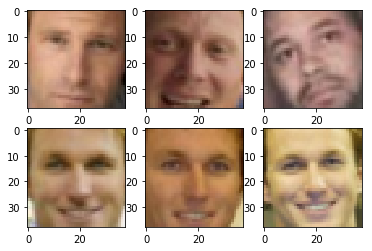

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [0]:
# this class corresponds to view-function and may be used as a reshape layer 

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(input.size(0), *self.shape)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class pca_autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, x, y, code_size=32):
        super(pca_autoencoder, self).__init__()
        self.enc = nn.Sequential()
        self.enc.add_module('flat', Flatten())
        self.enc.add_module('encoder', nn.Linear(x * y * 3, code_size, bias=True))

        self.dec = nn.Sequential()
        self.dec.add_module('decoder', nn.Linear(code_size, x * y * 3, bias=True))
        self.dec.add_module('reshape', View(3, x, y))
    
    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [0]:
def train(model, dataset, num_epoch=32):
    model.double()
    model.to(device)
    gd = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        steps = 0
        for i, batch in enumerate(dataloader):
            steps += 1
            gd.zero_grad()
            loss = model.batch_loss(batch.cuda())
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses[-steps:])),flush=True)

In [0]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    code = model.enc(img[None].cuda())
    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [11]:
aenc = pca_autoencoder(img_shape[1], img_shape[2])
train(aenc, X_train_tensor, 40)

#1, Train loss: 0.1266621
#2, Train loss: 0.0214059
#3, Train loss: 0.0211532
#4, Train loss: 0.0209616
#5, Train loss: 0.0207719
#6, Train loss: 0.0205156
#7, Train loss: 0.0200299
#8, Train loss: 0.0189454
#9, Train loss: 0.0175261
#10, Train loss: 0.0163862
#11, Train loss: 0.0149052
#12, Train loss: 0.0133933
#13, Train loss: 0.0121803
#14, Train loss: 0.0110747
#15, Train loss: 0.0099705
#16, Train loss: 0.0091292
#17, Train loss: 0.0083595
#18, Train loss: 0.0076582
#19, Train loss: 0.0071434
#20, Train loss: 0.0066764
#21, Train loss: 0.0064169
#22, Train loss: 0.0061513
#23, Train loss: 0.0060199
#24, Train loss: 0.0058764
#25, Train loss: 0.0057573
#26, Train loss: 0.0057315
#27, Train loss: 0.0056279
#28, Train loss: 0.0056707
#29, Train loss: 0.0056193
#30, Train loss: 0.0055735
#31, Train loss: 0.0055751
#32, Train loss: 0.0055695
#33, Train loss: 0.0055434
#34, Train loss: 0.0055106
#35, Train loss: 0.0055279
#36, Train loss: 0.0055297
#37, Train loss: 0.0055207
#38, Train

In [12]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc.batch_loss(batch.cuda()).data.cpu().numpy())
print (np.mean(scores))

0.0056013251411671915


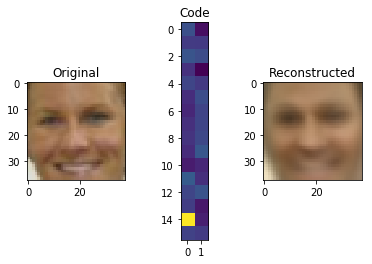

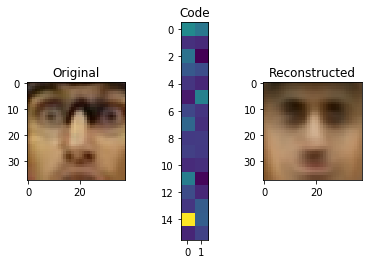

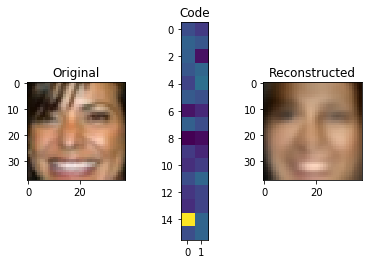

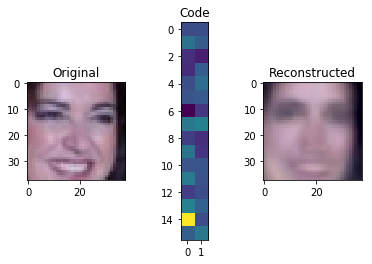

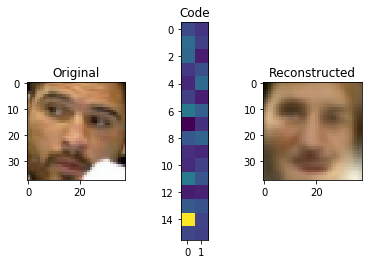

In [13]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc)

### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are good idea. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [0]:
class pca_autoencoder_deep(nn.Module):
    def __init__(self, x, y, code_size=32):
        super(pca_autoencoder_deep, self).__init__()

        out_channels = 16
        self.enc = nn.Sequential()
        self.enc.add_module('conv-1', nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=3, padding = 1, bias = False))
        self.enc.add_module('elu-1', nn.ELU())
        self.enc.add_module('conv-2', nn.Conv2d(in_channels=out_channels, out_channels=out_channels * 2, kernel_size=3, padding = 1, bias = False))
        self.enc.add_module('elu-2', nn.ELU())
        self.enc.add_module('conv-3', nn.Conv2d(in_channels=out_channels * 2, out_channels=out_channels * 4, kernel_size=3, padding = 1, bias = False))
        self.enc.add_module('flat', Flatten())
        self.enc.add_module('dense-1', nn.Linear(out_channels * x * y * 4, code_size))
        
        self.dec = nn.Sequential()
        self.dec.add_module('decocder', nn.Linear(code_size, out_channels * x * y * 4))
        self.dec.add_module('reshape', View(out_channels * 4, x, y))
        self.dec.add_module('conv-1', nn.ConvTranspose2d(in_channels=out_channels * 4, out_channels=out_channels * 2, kernel_size=3, padding = 1, bias = False))
        self.dec.add_module('elu-1', nn.ELU())
        self.dec.add_module('conv-2', nn.ConvTranspose2d(in_channels=out_channels * 2, out_channels=out_channels, kernel_size=3, padding = 1, bias = False))
        self.dec.add_module('elu-2', nn.ELU())
        self.dec.add_module('conv-3', nn.ConvTranspose2d(in_channels=out_channels, out_channels=3, kernel_size=3, padding = 1, bias = False))
        
    def summary(self, x, y):
      from torchsummary import summary
      summary(self.enc.to(device), (3, x, y))
      summary(self.dec.to(device), (1, 32))
        

    def batch_loss(self, batch):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((batch - reconstruction)**2)

In [15]:
aenc_deep = pca_autoencoder_deep(X_train_tensor.shape[2], X_train_tensor.shape[3])
aenc_deep.summary(X_train_tensor.shape[2], X_train_tensor.shape[3])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 38, 38]             432
               ELU-2           [-1, 16, 38, 38]               0
            Conv2d-3           [-1, 32, 38, 38]           4,608
               ELU-4           [-1, 32, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          18,432
           Flatten-6                [-1, 92416]               0
            Linear-7                   [-1, 32]       2,957,344
Total params: 2,980,816
Trainable params: 2,980,816
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.47
Params size (MB): 11.37
Estimated Total Size (MB): 13.86
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               

In [16]:
aenc_deep = pca_autoencoder_deep(img_shape[1], img_shape[2])
train(aenc_deep, X_train_tensor, 40)

#1, Train loss: 0.0300039
#2, Train loss: 0.0105071
#3, Train loss: 0.0086382
#4, Train loss: 0.0074686
#5, Train loss: 0.0068129
#6, Train loss: 0.0065505
#7, Train loss: 0.0062485
#8, Train loss: 0.0061661
#9, Train loss: 0.0059649
#10, Train loss: 0.0059548
#11, Train loss: 0.0058072
#12, Train loss: 0.0057706
#13, Train loss: 0.0057223
#14, Train loss: 0.0056711
#15, Train loss: 0.0056222
#16, Train loss: 0.0055657
#17, Train loss: 0.0055012
#18, Train loss: 0.0053816
#19, Train loss: 0.0053598
#20, Train loss: 0.0052706
#21, Train loss: 0.0051804
#22, Train loss: 0.0050638
#23, Train loss: 0.0049859
#24, Train loss: 0.0048830
#25, Train loss: 0.0048179
#26, Train loss: 0.0047576
#27, Train loss: 0.0047082
#28, Train loss: 0.0046503
#29, Train loss: 0.0046084
#30, Train loss: 0.0045449
#31, Train loss: 0.0045195
#32, Train loss: 0.0044773
#33, Train loss: 0.0044381
#34, Train loss: 0.0044195
#35, Train loss: 0.0043512
#36, Train loss: 0.0043356
#37, Train loss: 0.0043135
#38, Train

Training may take long, it's okay.

**Check autoencoder shapes along different code_sizes. Check architecture of you encoder-decoder network is correct**

In [17]:
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = pca_autoencoder_deep(X_train_tensor.shape[2], X_train_tensor.shape[3], code_size).to(device)
    encoder_out = model.enc(help_tensor.type('torch.FloatTensor').cuda())
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:]==torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:]==img_shape,   "decoder must output an image of valid shape"

    assert (len(list(model.dec.children())) >= 6),  "decoder must contain at least 3 dense layers"

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

** Lets check you model's score. You should beat value of 0.005 **

0.0048291310932751085
Final MSE: 0.0048291310932751085


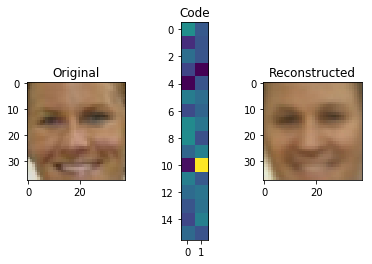

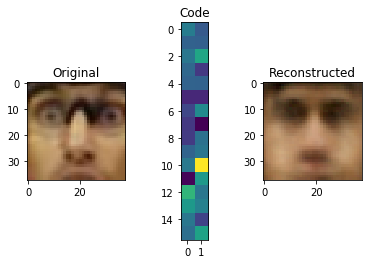

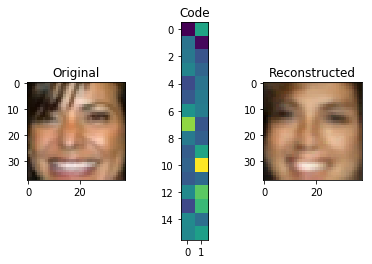

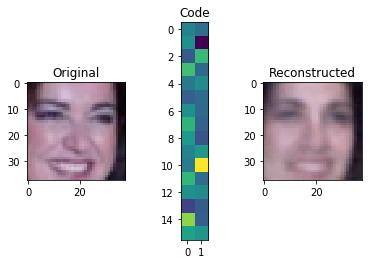

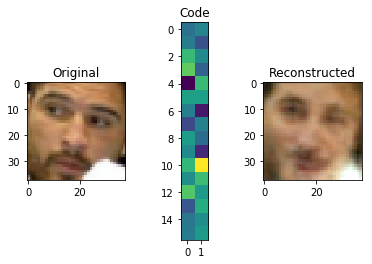

In [19]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    scores.append(aenc_deep.batch_loss(batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)
print(reconstruction_mse)

assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder_out.shape)==2 and encoder_out.shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [0]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
        
    noise = np.random.normal(scale = sigma, size = X.shape)
        
    return X + noise
    

In [0]:
class pca_autoencoder_deep_noise(nn.Module):
    def __init__(self, x, y, code_size=32):
        super(pca_autoencoder_deep_noise, self).__init__()

        out_channels = 16
        self.enc = nn.Sequential()
        self.enc.add_module('conv-1', nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=3, padding = 1, bias = False))
        self.enc.add_module('elu-1', nn.ELU())
        self.enc.add_module('conv-2', nn.Conv2d(in_channels=out_channels, out_channels=out_channels * 2, kernel_size=3, padding = 1, bias = False))
        self.enc.add_module('elu-2', nn.ELU())
        self.enc.add_module('conv-3', nn.Conv2d(in_channels=out_channels * 2, out_channels=out_channels * 4, kernel_size=3, padding = 1, bias = False))
        self.enc.add_module('flat', Flatten())
        self.enc.add_module('dense-1', nn.Linear(out_channels * x * y * 4, code_size))
        
        self.dec = nn.Sequential()
        self.dec.add_module('decocder', nn.Linear(code_size, out_channels * x * y * 4))
        self.dec.add_module('reshape', View(out_channels * 4, x, y))
        self.dec.add_module('conv-1', nn.ConvTranspose2d(in_channels=out_channels * 4, out_channels=out_channels * 2, kernel_size=3, padding = 1, bias = False))
        self.dec.add_module('elu-1', nn.ELU())
        self.dec.add_module('conv-2', nn.ConvTranspose2d(in_channels=out_channels * 2, out_channels=out_channels, kernel_size=3, padding = 1, bias = False))
        self.dec.add_module('elu-2', nn.ELU())
        self.dec.add_module('conv-3', nn.ConvTranspose2d(in_channels=out_channels, out_channels=3, kernel_size=3, padding = 1, bias = False))
        
    def summary(self, x, y):
      from torchsummary import summary
      summary(self.enc.to(device), (3, x, y))
      summary(self.dec.to(device), (1, 32))
        

    def batch_loss(self, batch, noise_batch):
        reconstruction = self.dec(self.enc(noise_batch))
        return torch.mean((batch - reconstruction)**2)

**noise tests**

In [0]:
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

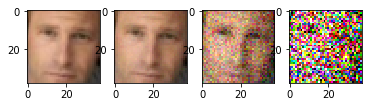

In [28]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0].transpose([1,2,0]).clip(0, 1))

In [0]:
def train_noise(model, dataset, num_epoch=50, sigma=0.1):
    model.double()
    model.to(device)
    gd = optim.Adamax(model.parameters(), lr=0.002)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in range(num_epoch):
        steps = 0
        for i, batch in enumerate(dataloader):
            steps += 1
            noisy_batch = apply_gaussian_noise(batch.data.numpy(), sigma=sigma)
            noisy_batch = torch.Tensor(noisy_batch).double()
            gd.zero_grad()
            loss = model.batch_loss(batch.cuda(), noisy_batch.cuda())
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1, np.mean(losses[-steps:])),flush=True)

In [36]:
aenc = pca_autoencoder_deep_noise(img_shape[1], img_shape[2])
train_noise(aenc, X_train_tensor)

#1, Train loss: 0.0399500
#2, Train loss: 0.0129065
#3, Train loss: 0.0104927
#4, Train loss: 0.0087775
#5, Train loss: 0.0079860
#6, Train loss: 0.0075597
#7, Train loss: 0.0071987
#8, Train loss: 0.0070423
#9, Train loss: 0.0066879
#10, Train loss: 0.0065322
#11, Train loss: 0.0064126
#12, Train loss: 0.0062425
#13, Train loss: 0.0061045
#14, Train loss: 0.0060114
#15, Train loss: 0.0059363
#16, Train loss: 0.0058590
#17, Train loss: 0.0057595
#18, Train loss: 0.0056672
#19, Train loss: 0.0055739
#20, Train loss: 0.0054748
#21, Train loss: 0.0053797
#22, Train loss: 0.0052672
#23, Train loss: 0.0051821
#24, Train loss: 0.0050961
#25, Train loss: 0.0050493
#26, Train loss: 0.0049900
#27, Train loss: 0.0049370
#28, Train loss: 0.0049031
#29, Train loss: 0.0048423
#30, Train loss: 0.0047974
#31, Train loss: 0.0047538
#32, Train loss: 0.0047078
#33, Train loss: 0.0046654
#34, Train loss: 0.0046288
#35, Train loss: 0.0046124
#36, Train loss: 0.0045724
#37, Train loss: 0.0045463
#38, Train

__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

** Let's evaluate!!! **

Final MSE: 0.004856251069008036


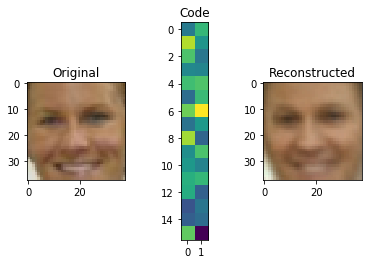

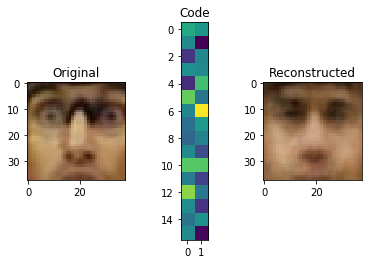

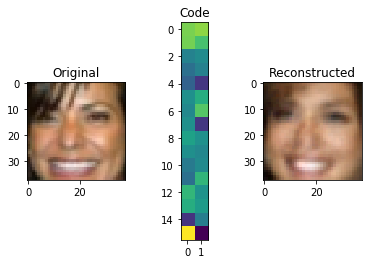

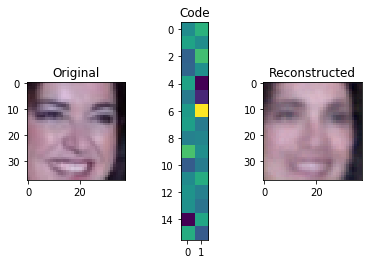

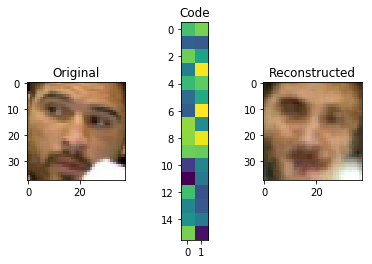

In [39]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    noisy_batch = apply_gaussian_noise(batch.data.numpy())
    noisy_batch = torch.Tensor(noisy_batch).double()
    scores.append(aenc.batch_loss(batch.cuda(device = device), noisy_batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(noisy_batch.cuda(device = device))
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [0]:
#encodes batch of images into a codes


codes = #<Your code:encode all images in X_train_tensor>


In [0]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [0]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

In [0]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [0]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape)==3,"image must be [batch,height,width,3]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = #<Your code: using lshf.kneighbors find nearest neighbors>
    
    return distances,images[idx]

In [0]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [0]:
#smiles
show_similar(X_test_tensor[2])

In [0]:
#ethnicity
show_similar(X_test_tensor[500])

In [0]:
#glasses
show_similar(X_test_tensor[66])

## Cheap image morphing


Here you should take two full-sized objects, code it and obtain intermediate object by decoding an intermixture code.

$Code_{mixt} = a1\cdot code1 + a2\cdot code2$

In [0]:

for _ in range(5):
    image1,image2 =#<Your code:choose two image randomly>

    code1, code2 = #<Your code:decode it>


    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = #<Your code:define intermixture code>

        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1,2,0]))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.